## 预处理

In [23]:
import numpy as np
import pandas as pd
import networkx as nx
from collections import defaultdict
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


%config InlineBackend.figure_format = 'svg'
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
%matplotlib notebook
%matplotlib notebook

In [3]:
# nbaData = pd.read_csv('./data/nba/nba.csv')
# nbaData.head()

In [4]:
lionData = pd.read_csv('./data/lion-reference.csv',header=None)
lionData.head()

,0,1,2
0,-0.040110,0.224513,-0.064178
1,-0.035460,0.234662,-0.091287
2,-0.028643,0.226311,-0.091565
3,-0.036914,0.239158,-0.110594
4,-0.029853,0.231213,-0.112309


In [5]:
# cactusData = pd.read_csv('./data/Cactus.txt',header=None,sep='\t')
# cactusData.head()

In [6]:
# catData = pd.read_csv('./data/cat-reference.csv',header=None)
# catData.head()

寻找一种好的降维方法，正交化？

In [7]:
data = lionData

In [8]:
N = len(data)
print("N :",N)

N : 5000


**设定最近邻的参数K**

In [9]:
k = 20

预处理

In [10]:
# scaler = preprocessing.StandardScaler()
# print(scaler.fit(data))
# print(scaler.mean_)
# a = scaler.transform(data)
a = data.values

In [11]:
neigh = NearestNeighbors(n_neighbors=k+1) # 因为之后提取最近点时会包括点自身
neigh.fit(a)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=21, p=2, radius=1.0)

In [12]:
disMat,nodeMat = neigh.kneighbors(a)

In [13]:
print(disMat.shape)
print(disMat)

(5000, 21)
[[0.         0.01197017 0.02130539 ... 0.04966578 0.0503693  0.05050952]
 [0.         0.01078369 0.01987683 ... 0.03546798 0.03547839 0.03713191]
 [0.         0.01078369 0.01686036 ... 0.03943338 0.0394857  0.04111569]
 ...
 [0.         0.00308663 0.00691043 ... 0.01399195 0.01438966 0.01444282]
 [0.         0.00162269 0.00943922 ... 0.01939571 0.0194634  0.01956348]
 [0.         0.01197017 0.01615658 ... 0.05116897 0.05202735 0.05301784]]


In [14]:
print(nodeMat.shape)
print(nodeMat)

(5000, 21)
[[   0 4999   38 ...    4  247   52]
 [   1    2    3 ...   64  115   89]
 [   2    1   99 ...   98   90 4305]
 ...
 [4997 4994 4985 ... 4940 4965 4996]
 [4998 4995 4986 ... 4993 4976 4939]
 [4999    0  101 ...  116    3   92]]


<IPython.core.display.Javascript object>


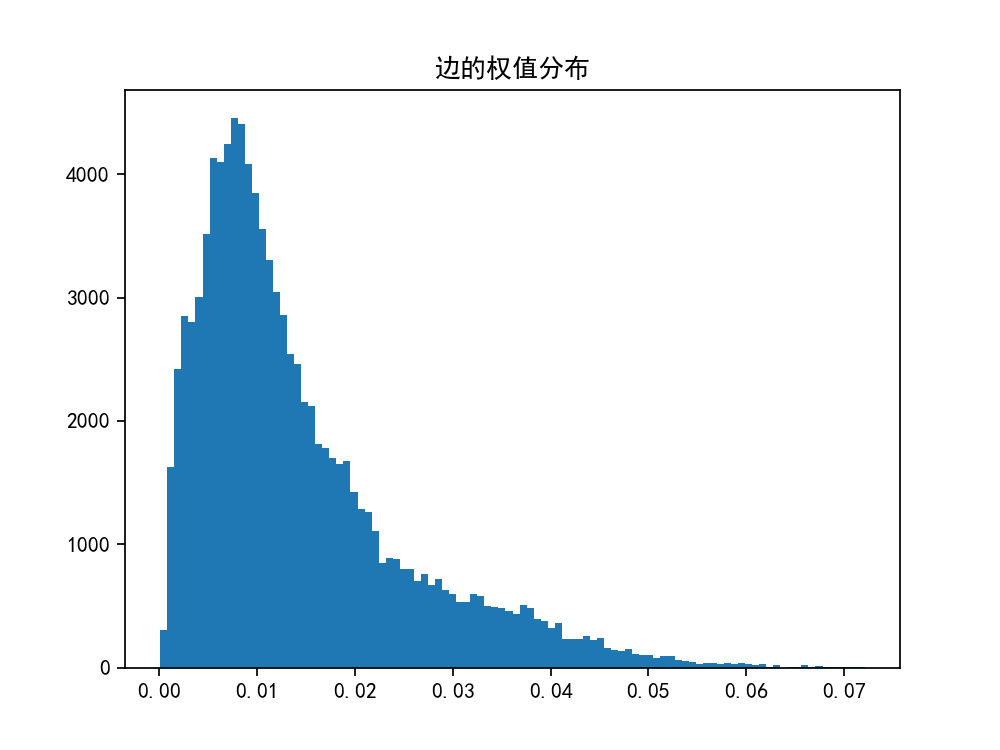

(array([3.020e+02, 1.622e+03, 2.420e+03, 2.852e+03, 2.800e+03, 3.002e+03,
        3.518e+03, 4.130e+03, 4.103e+03, 4.244e+03, 4.460e+03, 4.407e+03,
        4.081e+03, 3.847e+03, 3.556e+03, 3.305e+03, 3.047e+03, 2.857e+03,
        2.540e+03, 2.459e+03, 2.155e+03, 2.122e+03, 1.811e+03, 1.784e+03,
        1.700e+03, 1.649e+03, 1.675e+03, 1.422e+03, 1.289e+03, 1.265e+03,
        1.104e+03, 8.500e+02, 8.870e+02, 8.790e+02, 7.970e+02, 7.970e+02,
        7.040e+02, 7.560e+02, 6.680e+02, 7.200e+02, 6.310e+02, 6.000e+02,
        5.280e+02, 5.290e+02, 5.920e+02, 5.790e+02, 5.020e+02, 4.920e+02,
        4.860e+02, 4.610e+02, 4.360e+02, 5.040e+02, 4.850e+02, 3.960e+02,
        3.760e+02, 3.180e+02, 3.580e+02, 2.310e+02, 2.330e+02, 2.320e+02,
        2.560e+02, 2.220e+02, 2.360e+02, 1.580e+02, 1.420e+02, 1.320e+02,
        1.500e+02, 1.110e+02, 9.900e+01, 1.000e+02, 7.300e+01, 9.400e+01,
        9.400e+01, 6.400e+01, 5.600e+01, 4.800e+01, 3.000e+01, 3.400e+01,
        3.400e+01, 3.200e+01, 3.600e+0

In [15]:
a = disMat.flatten()
plt.title('边的权值分布');
plt.hist(a[a.nonzero()],bins=100)

## 建图

In [16]:
G = nx.Graph()

In [17]:
G.add_nodes_from(range(nodeMat.shape[0]))

In [18]:
edges = []
for i,(neighbors,distances) in enumerate(zip(nodeMat,disMat)):
    edges +=[(i, neighbors[j], distances[j]) for j in range(k+1) if neighbors[j]!=i]
print(edges[:5])

[(0, 4999, 0.011970165119997316), (0, 38, 0.021305392322132907), (0, 101, 0.027091750072669736), (0, 1, 0.029317615557886006), (0, 2, 0.0297451283742397)]


In [19]:
G.add_weighted_edges_from(edges)

In [20]:
print('node size',len(G.nodes))

node size 5000


### 3D

<IPython.core.display.Javascript object>


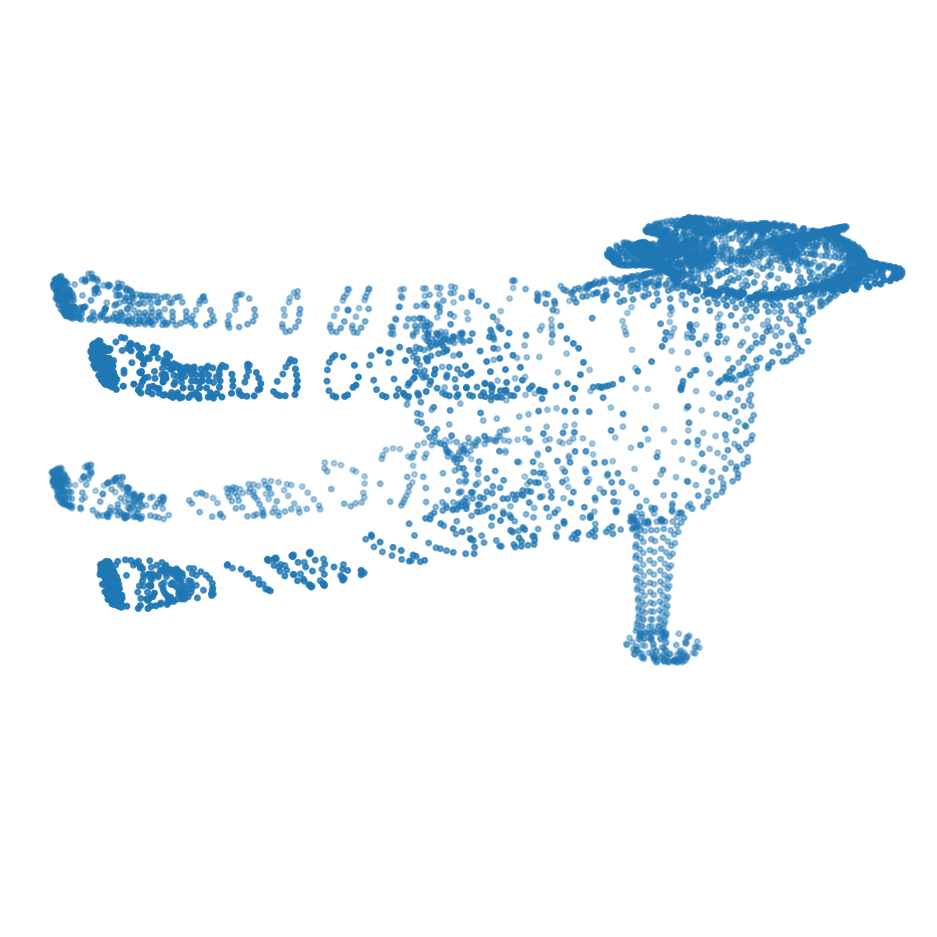

(-0.1429033, 0.14288330000000002, -0.01597155, 0.4850465499999999)

In [22]:
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.scatter3D(*data.to_numpy().T,marker='.')
ax.axis('off')
# for a,b,_ in edges:
#     if np.random.rand()>0.5:
#         ax.plot(*data.iloc[[a,b]].to_numpy().T,alpha=0.5,color='c')
ax.axis('equal')

### plain

In [22]:
# plt.figure(figsize=(8,8))
# pos = nx.spring_layout(G)
# nx.draw(G,node_shape='o',pos=pos,node_size=30,node_color='c',edge_color='#A0CBE2')

## 投票

https://networkx.github.io/documentation/stable/reference/algorithms/shortest_paths.html

In [161]:
dis = dict(nx.all_pairs_bellman_ford_path_length(G))

In [162]:
with open('disMat','w') as f:
    f.write(str(N)+'\n')
    for i in range(N):
        for j in range(N):
            try:
                d = dis[i][j]
            except KeyError:
                d = -1
            f.write(str(d)+' ')

In [163]:
del dis

仅作为参考，现在使用c实现这一部分
```
nodeIdx = list(range(N))
samples = 50000
subSamples = 10000
th = 0.01
conditon = lambda a,b,c,d:abs(dis[a][b]-dis[c][d])<th and abs(dis[a][d]-dis[b][c])<th

votes = defaultdict(int)

for i in range(samples):
    a,b,c,d=np.random.choice(nodeIdx,4)
    if conditon(a,b,c,d):
        for j in range(subSamples):
            e,f = np.random.choice(nodeIdx,2)
            if conditon(a,b,e,f) and conditon(c,d,e,f):
                if b>a:
                    a,b=b,a
                if d>c:
                    c,d=d,c
                votes[(a,b)]+=1
                votes[(c,d)]+=1
```

In [19]:
a = np.loadtxt('./out.txt')
votes = defaultdict(int)
for i,j in zip(a.nonzero()[0],a.nonzero()[1]):
    v = a[i,j]
    assert v>0
    if i==j:continue
    if i<j:
        i,j=j,i
    votes[(i,j)] += v
del a

In [20]:
votes

defaultdict(int,
            {(879, 0): 1.0,
             (1303, 0): 5.0,
             (3744, 0): 1.0,
             (3905, 0): 1.0,
             (769, 1): 3.0,
             (2013, 1): 1.0,
             (63, 3): 14.0,
             (2226, 3): 1.0,
             (2209, 4): 1.0,
             (1917, 5): 4.0,
             (1913, 6): 10.0,
             (1552, 7): 1.0,
             (3136, 7): 2.0,
             (146, 10): 1.0,
             (2946, 10): 5.0,
             (4306, 12): 2.0,
             (2494, 13): 2.0,
             (1888, 14): 1.0,
             (3008, 14): 8.0,
             (3176, 14): 2.0,
             (4381, 17): 5.0,
             (1190, 21): 1.0,
             (22, 21): 15.0,
             (4379, 22): 1.0,
             (1561, 25): 1.0,
             (3138, 25): 1.0,
             (3150, 25): 1.0,
             (115, 26): 1.0,
             (2768, 27): 1.0,
             (2595, 28): 2.0,
             (3914, 29): 1.0,
             (143, 30): 1.0,
             (318, 30): 1.0,
             

<IPython.core.display.Javascript object>


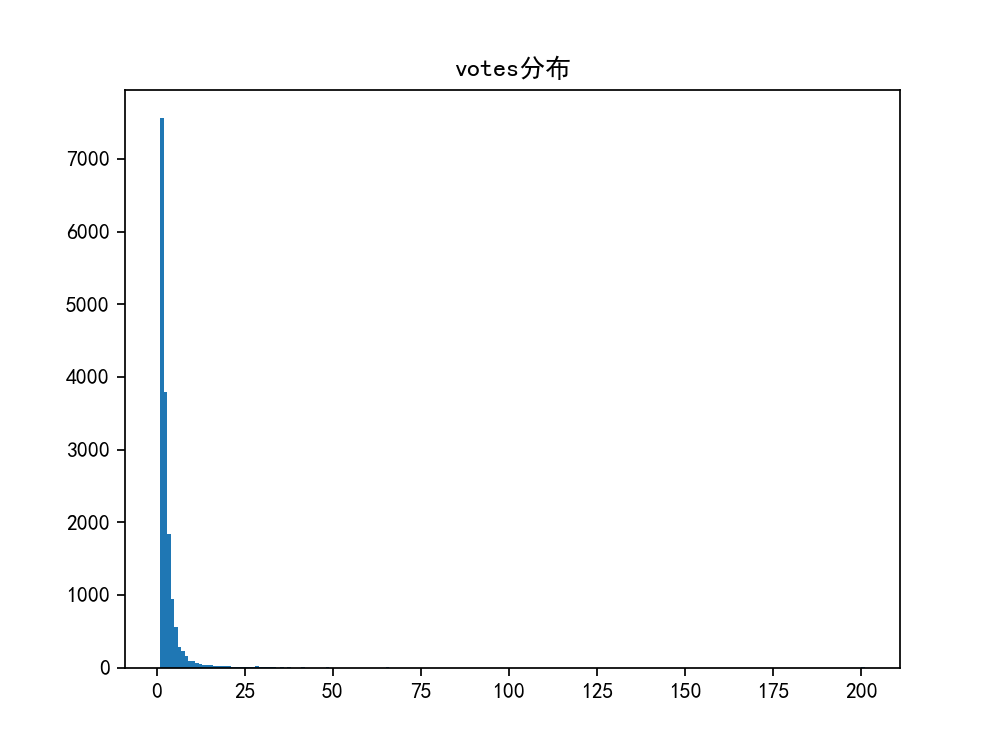

(array([7.569e+03, 3.785e+03, 1.837e+03, 9.420e+02, 5.610e+02, 2.870e+02,
        2.320e+02, 1.590e+02, 8.800e+01, 9.500e+01, 6.700e+01, 4.500e+01,
        3.600e+01, 3.800e+01, 3.100e+01, 2.300e+01, 2.100e+01, 1.400e+01,
        1.800e+01, 2.200e+01, 4.000e+00, 8.000e+00, 8.000e+00, 1.200e+01,
        6.000e+00, 6.000e+00, 2.000e+00, 1.800e+01, 4.000e+00, 4.000e+00,
        8.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 4.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

In [21]:
# plt.xlim((0,50))
plt.title('votes分布')
plt.hist(votes.values(),bins=200)

In [50]:
th_votes = 2

In [51]:
voteDict = defaultdict(set)
for a,b in votes.keys():
    if votes[(a,b)]>th_votes:
        voteDict[b].add(a) # 使 key <= value
print('len of voteDict',len(voteDict))
print(voteDict)

len of voteDict 2203
defaultdict(<class 'set'>, {0: {1303}, 1: {769, 3067}, 3: {2801, 2342, 63}, 5: {1917}, 6: {1913, 2342}, 10: {2946}, 14: {3008}, 17: {4381}, 21: {22}, 38: {2273}, 40: {1891, 59}, 59: {1896, 3106, 2567}, 60: {2867, 227}, 67: {3598, 2919}, 75: {1265}, 77: {2422}, 85: {201, 86}, 86: {2710, 1916, 1782}, 112: {2555}, 115: {4385}, 123: {2456}, 127: {3931, 2020}, 132: {3739, 2124}, 133: {2895}, 134: {287}, 22: {139}, 147: {3100}, 161: {3069, 165}, 168: {197}, 181: {3443, 3005}, 190: {712}, 198: {2050}, 214: {2305, 1722, 2437}, 221: {2697, 2099, 3692}, 227: {2438}, 231: {1839}, 235: {1411}, 243: {2923}, 253: {256}, 259: {3105}, 261: {289}, 276: {2379}, 277: {2033, 3725}, 282: {2698}, 285: {2506}, 290: {3389}, 294: {1698, 3419}, 295: {2321, 1139}, 298: {2276, 2007}, 299: {1176, 3363}, 301: {3358}, 304: {1706, 1859, 2062}, 305: {1689, 2341}, 309: {338}, 317: {417}, 323: {2461}, 325: {711}, 124: {327}, 330: {2994, 334}, 331: {508}, 334: {336}, 336: {3117}, 337: {1384}, 341: {4

通过距离中点得到nodeSet

In [ ]:
# nodeSet = set()
# for i in voteDict.keys():
#     for b in voteDict[i]:
#         pi = nx.dijkstra_path(G,i,b)
#         dis_half = dis[i][b]/2
#         minAbs = dis_half
#         minNode = i
#         for node in pi:
#             tAbs = abs(dis[i][node]-dis_half)
#             if tAbs<minAbs:
#                 minAbs = tAbs
#                 minNode = node
#         nodeSet.add(minNode)
# print('len of nodeSet:',len(nodeSet))
# print(nodeSet)

通过跳数中点得到nodeSet

In [52]:
nodeSet = set()
for i in voteDict.keys():
    for b in voteDict[i]:
        pi = nx.dijkstra_path(G,i,b)
        nodeSet.add(pi[len(pi)//2])
print('len of nodeSet:',len(nodeSet))
print(nodeSet)

len of nodeSet: 1202
{2051, 2052, 4396, 2055, 2056, 2057, 2060, 2064, 19, 22, 2070, 2071, 2080, 2082, 2088, 2095, 2096, 2097, 2098, 2099, 2100, 53, 2102, 2103, 2106, 59, 63, 2112, 2114, 2115, 2117, 2118, 2119, 2121, 2122, 2123, 2124, 2126, 2127, 2128, 2130, 84, 2134, 3681, 2139, 2141, 2143, 2145, 2146, 2149, 2150, 2154, 2155, 2156, 2157, 2159, 2160, 2161, 2162, 2163, 2164, 2174, 2175, 2176, 2177, 2179, 2180, 2182, 135, 2183, 2186, 2187, 2188, 2190, 2194, 3693, 2202, 3181, 2207, 165, 2213, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2233, 2234, 2235, 2246, 2249, 2250, 2252, 2257, 2259, 2262, 219, 2270, 4320, 1674, 2281, 234, 238, 3711, 2289, 2290, 2291, 2292, 3712, 2293, 2295, 2296, 2298, 2299, 2301, 2303, 1679, 257, 258, 2310, 2312, 2313, 2314, 2315, 2316, 2317, 270, 271, 2319, 2321, 2323, 2324, 2325, 3718, 2327, 282, 283, 2331, 2333, 2334, 2335, 2336, 4385, 3721, 2339, 2340, 2341, 295, 2343, 2345, 2346, 2347, 3723, 301, 302, 303, 304, 305, 306, 2355, 

## 构建子图

### 3D

<IPython.core.display.Javascript object>


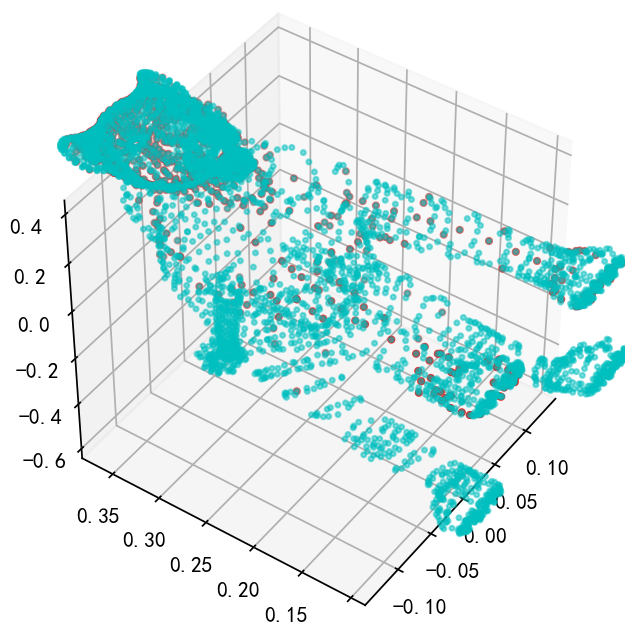

(-0.1429033, 0.14288330000000002, -0.01597155, 0.4850465499999999)

In [53]:
fig = plt.figure(figsize=(4,4))
ax = Axes3D(fig)
ax.scatter3D(*data.to_numpy().T,marker='.',color='c',alpha=0.5)
ax.scatter3D(*data.iloc[[*nodeSet]].to_numpy().T,marker='.',s=30,color='r')
ax.axis('equal')

In [54]:
G2 = G.subgraph(nodeSet)
edgeSet = G2.edges() # not set actually

<IPython.core.display.Javascript object>


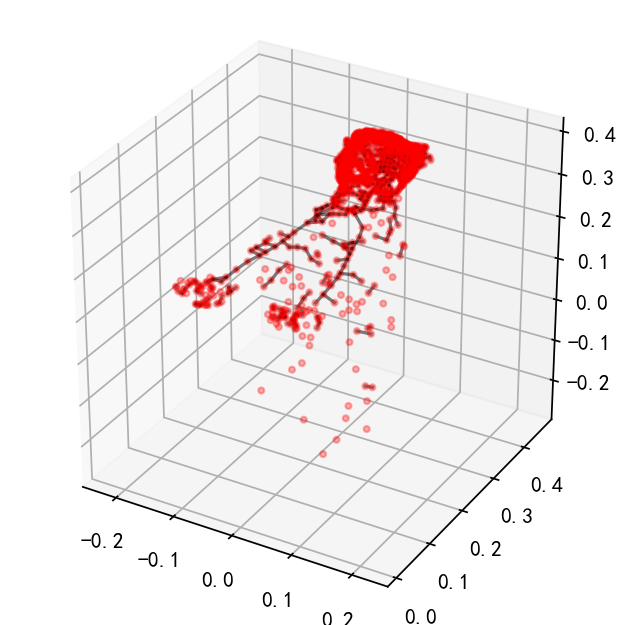

(-0.11983510000000001,
 0.11983510000000001,
 -0.014583350000000002,
 0.48187635000000006)

In [55]:
fig = plt.figure(figsize=(4,4))
ax = Axes3D(fig)
# ax.scatter3D(*data.to_numpy().T,marker='.',color='c',alpha=0.5)
ax.scatter3D(*data.iloc[[*nodeSet]].to_numpy().T,marker='.',s=30,color='r',alpha=0.3)
for a,b in edgeSet:
    if np.random.rand()>-1:
        ax.plot(*data.iloc[[a,b]].to_numpy().T,alpha=0.5,color='k')
ax.axis('equal')

### plain

**在原图位置上展示**

In [25]:
nodeSet = {2048, 2049, 2, 2051, 4, 2053, 2054, 7, 2055, 2057, 11, 2061, 2063, 17, 2065, 2067, 2070, 2071, 2072, 4119, 26, 27, 28, 2077, 30, 2079, 2080, 2083, 2087, 2088, 41, 2091, 45, 2094, 46, 49, 2097, 2099, 2098, 2101, 2102, 2103, 4148, 2105, 2109, 2110, 2111, 65, 2113, 67, 4165, 4166, 2119, 4168, 2121, 2124, 78, 79, 80, 81, 82, 83, 84, 85, 4176, 4183, 88, 2138, 90, 92, 2145, 2146, 2147, 99, 101, 102, 2151, 98, 2158, 2161, 2162, 2163, 116, 114, 118, 2167, 4212, 4215, 122, 2173, 4221, 2175, 129, 136, 144, 146, 2195, 147, 2198, 150, 4248, 152, 156, 160, 2208, 4257, 165, 4261, 4262, 4270, 2224, 4273, 2227, 181, 186, 4283, 188, 2238, 191, 193, 195, 197, 4294, 200, 2253, 206, 4303, 2257, 4307, 2260, 2263, 219, 2267, 2270, 4320, 226, 4322, 228, 230, 231, 232, 2279, 2282, 235, 236, 2287, 2289, 2292, 2293, 247, 250, 2299, 2301, 255, 257, 2306, 260, 261, 262, 2310, 265, 266, 267, 2314, 2315, 270, 2319, 2320, 269, 2323, 2324, 2325, 4375, 2328, 281, 2330, 2329, 284, 2332, 2334, 2335, 288, 2337, 2338, 2339, 292, 293, 2341, 295, 2343, 2344, 290, 301, 2349, 303, 304, 305, 306, 2351, 308, 310, 2358, 313, 314, 315, 2363, 4410, 319, 320, 2373, 326, 2375, 2376, 2374, 2389, 2392, 346, 2399, 2400, 2401, 2402, 2404, 357, 358, 359, 365, 2416, 2424, 2427, 380, 2430, 2431, 2432, 2438, 2439, 2444, 399, 403, 2452, 404, 407, 2458, 2459, 2460, 2461, 2464, 417, 418, 2468, 421, 2473, 4522, 2475, 2477, 2478, 431, 2484, 2485, 2490, 443, 444, 2493, 2491, 2495, 448, 449, 450, 451, 2499, 453, 2502, 455, 2498, 4551, 458, 459, 2507, 2506, 466, 2515, 467, 2516, 2520, 477, 2526, 2525, 2528, 4575, 2531, 2536, 2542, 497, 2545, 499, 2548, 4596, 4593, 2551, 2553, 2554, 508, 2557, 2561, 2562, 4609, 2566, 4614, 2575, 2576, 530, 2580, 2581, 534, 2582, 2583, 2584, 2586, 2585, 541, 4642, 2596, 550, 551, 554, 2602, 4653, 559, 2609, 4658, 565, 4662, 4664, 2618, 4667, 2621, 2623, 2625, 2626, 2628, 4684, 2640, 4700, 609, 2658, 613, 2661, 2663, 2664, 4709, 2666, 4712, 2668, 2670, 2671, 2672, 2674, 2676, 2677, 4728, 4729, 2683, 637, 2686, 2691, 4743, 2696, 4746, 2705, 2706, 4758, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 673, 2721, 2722, 676, 2725, 4772, 681, 4778, 4779, 2733, 686, 687, 2741, 4789, 696, 701, 2749, 2751, 2753, 2756, 2759, 713, 2764, 2769, 2770, 2771, 2773, 2779, 2780, 2781, 2789, 745, 2797, 4845, 2800, 2801, 2803, 2805, 2806, 2807, 2809, 2810, 2812, 2813, 767, 2815, 2819, 772, 2822, 2823, 4874, 2827, 2828, 4880, 2833, 2839, 2840, 4887, 800, 806, 2855, 2857, 810, 2860, 2871, 4921, 2876, 2879, 2880, 4928, 837, 2885, 2894, 2896, 4944, 2898, 859, 860, 2908, 4959, 4960, 2921, 876, 2928, 2930, 2936, 4986, 2944, 4996, 4997, 2951, 2952, 2953, 2954, 2955, 2960, 2962, 2963, 2964, 2966, 2969, 2970, 923, 924, 2972, 2975, 2979, 933, 2982, 2985, 2987, 940, 2989, 942, 2990, 944, 945, 951, 2999, 3001, 3005, 3008, 961, 3021, 3022, 3023, 976, 977, 3026, 3025, 3027, 3024, 3031, 3035, 993, 3043, 3045, 3047, 3049, 1007, 1013, 1016, 1017, 3068, 3071, 3076, 1039, 3087, 3088, 3091, 3093, 3094, 3095, 3097, 1050, 1051, 3103, 3105, 3110, 1064, 3113, 3115, 3117, 3118, 3120, 3121, 3122, 3123, 3125, 3126, 3130, 3131, 3140, 3141, 1094, 3142, 3146, 3154, 3155, 3156, 3158, 3159, 3160, 3163, 3164, 3169, 3170, 3173, 3174, 3176, 3177, 1132, 1136, 1138, 3187, 3193, 3197, 3198, 3199, 3202, 3204, 3205, 1168, 1169, 3217, 3219, 1172, 3220, 3221, 3218, 3223, 3228, 3235, 3240, 3248, 3250, 3253, 1206, 3256, 3265, 1229, 3280, 3281, 3282, 3283, 3289, 3290, 3295, 3296, 1258, 1262, 3312, 3313, 3319, 3325, 3344, 3349, 3351, 3354, 1307, 1308, 3357, 3360, 3361, 3365, 3368, 1321, 3375, 3376, 3378, 3380, 3384, 3387, 3388, 3389, 3390, 3391, 1344, 3395, 3397, 3398, 3399, 1353, 3404, 1359, 1360, 3411, 3430, 1383, 3433, 1392, 1395, 3446, 1400, 3449, 3450, 3452, 3453, 3454, 3458, 3460, 3465, 1418, 3468, 3469, 4760, 1423, 1427, 1430, 1434, 3483, 3484, 4763, 3486, 3487, 1441, 1445, 3493, 3495, 3496, 3497, 3498, 3500, 1453, 1454, 3502, 1458, 3506, 3507, 1462, 3511, 3510, 3513, 3515, 1470, 3518, 3520, 1472, 3523, 3524, 3526, 3527, 3528, 3530, 3531, 1486, 3535, 3537, 1491, 3539, 3540, 3542, 3545, 3548, 3551, 3555, 3557, 1510, 1513, 3568, 3569, 1522, 3578, 3579, 3580, 3582, 1535, 1536, 3587, 1541, 3590, 1543, 3589, 1546, 1547, 3595, 1551, 3600, 1553, 1556, 3604, 1561, 1562, 3609, 1564, 3613, 3614, 1567, 1569, 1571, 1572, 3625, 1579, 1585, 1586, 1587, 3640, 1595, 3649, 1603, 3651, 1605, 3652, 3655, 1608, 3653, 3658, 1612, 3664, 1625, 3674, 3678, 1636, 3685, 3689, 1643, 3691, 1645, 3693, 3695, 1650, 3700, 1653, 3701, 3703, 3704, 1657, 3702, 3707, 1660, 3705, 1663, 1664, 1665, 3712, 3713, 1668, 1670, 1674, 1675, 1677, 1679, 3728, 3730, 3733, 3734, 3735, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3751, 1709, 3757, 3758, 1712, 1720, 1721, 3769, 3775, 3777, 3778, 1732, 3780, 1734, 3782, 1737, 3788, 1742, 3791, 1745, 3794, 1747, 3797, 1753, 3801, 3806, 3807, 3808, 1761, 3809, 3810, 3812, 3817, 3825, 3827, 3829, 3830, 3831, 3834, 3838, 3839, 1796, 3845, 1798, 3847, 1799, 3849, 1800, 3851, 3848, 1808, 1822, 1823, 1835, 1843, 1854, 1856, 1866, 1877, 3927, 1886, 1894, 1895, 1896, 1897, 1901, 1904, 1912, 1913, 1914, 1916, 1919, 3969, 1924, 1925, 1942, 1949, 4007, 1961, 1966, 1970, 1971, 1972, 4019, 1976, 1979, 1982, 4030, 1988, 1994, 1995, 4049, 2005, 2006, 2007, 2008, 2009, 2015, 2017, 2020, 4069, 2026, 2028, 4079, 2033, 2035, 2036, 2040, 2041, 2043, 2046}

In [26]:
G2 = G.subgraph(nodeSet)

<IPython.core.display.Javascript object>


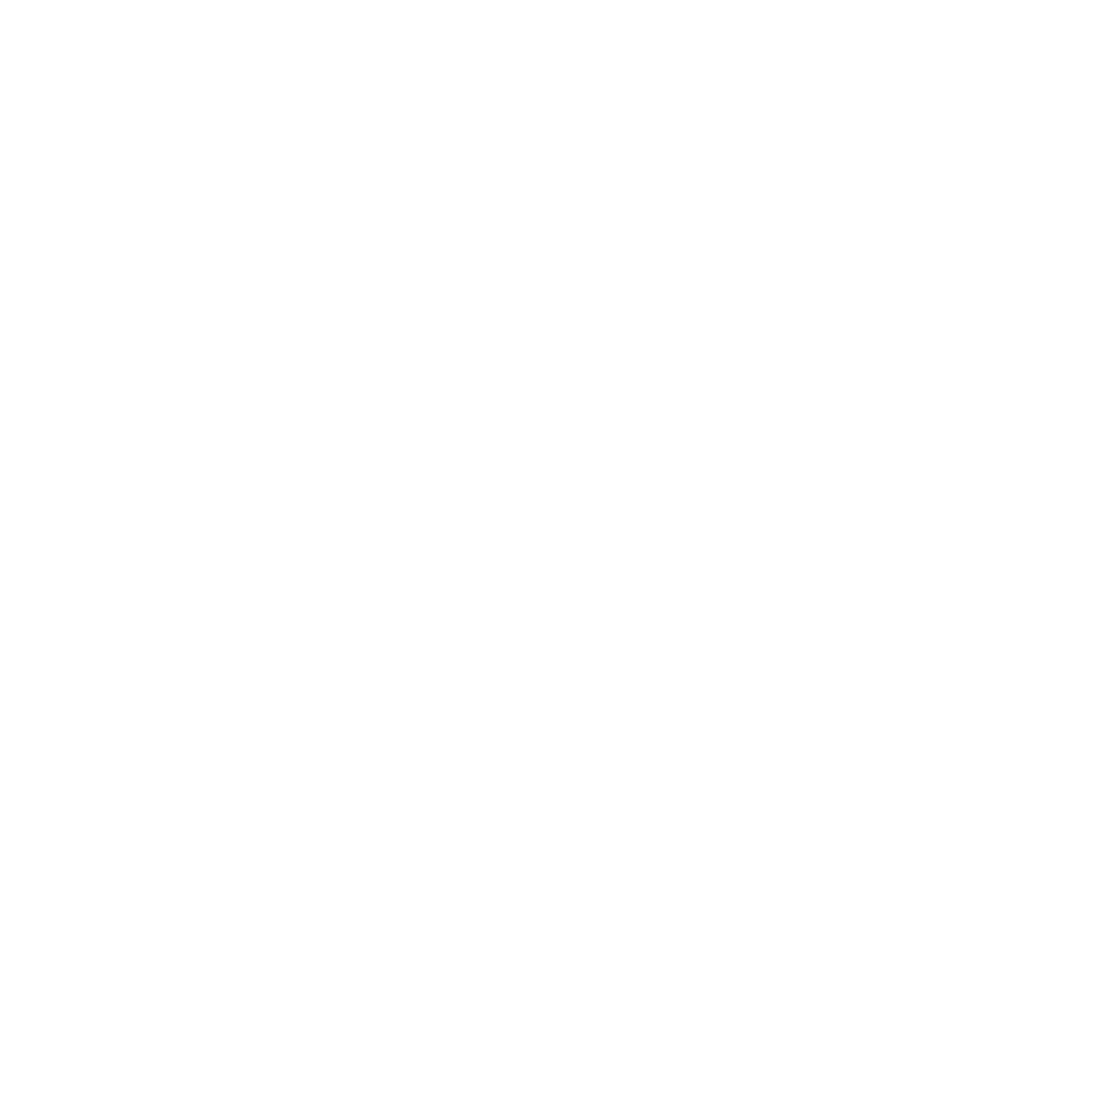

NameError: name 'pos' is not defined

In [44]:
plt.figure(figsize=(8,8))
nx.draw(G,node_shape='o',pos=pos,node_size=30,node_color='c' ,edge_color='#A0CBE2')
nx.draw(G2,node_shape='o',pos=pos, node_size=30,width=2)

**使用图布局算法(Fruchterman-Reingold force-directed algorithm)**

事实上默认就是用了图布局算法的

<IPython.core.display.Javascript object>


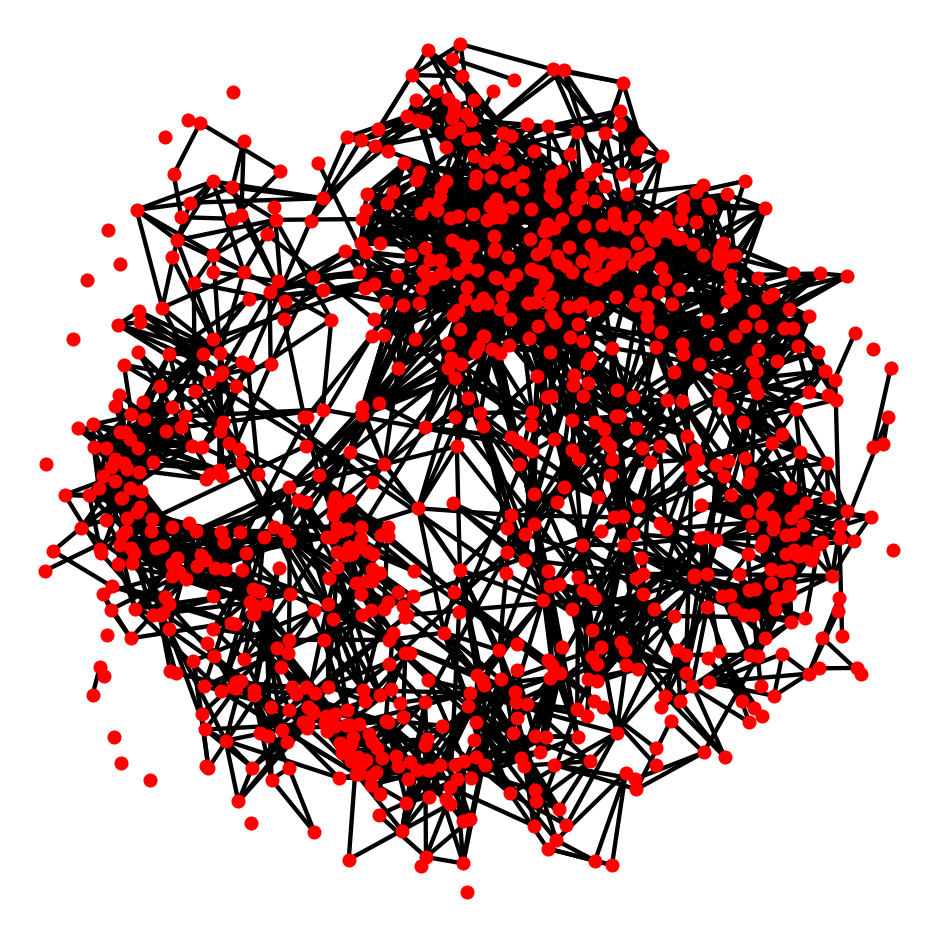

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


In [27]:
plt.figure(figsize=(6,6))
nx.draw(G2,node_shape='o',node_size=30,width=2)

### 导出json

In [123]:
def edge2json(G_):
    import json
    a = pd.DataFrame(G_.edges)
    nodes = sorted(a.iloc[:,0].append(a.iloc[:,1]).unique())
    del a
    id2nodes = dict(enumerate(nodes))
    nodes2id = {n:i for i,n in enumerate(nodes)}
    a = pd.DataFrame(G_.edges)
    a=a.assign(weight=a.apply(lambda x:G_.get_edge_data(x[0],x[1])['weight'],axis=1))
    def m(x):
        try:
            return nodes2id[x]
        except:
            return x
    a = a.applymap(m) # 假设权重不是整数！！！！
    links_list = list(a.apply(lambda row:{"source": int(row[0]), "target": int(row[1]), "weight": row['weight']},axis=1))
    nodes_list = [{'name': str(n)} for n in nodes]
    json_prep = {"nodes":nodes_list, "links":links_list}
    json_dump = json.dumps(json_prep, indent=1, sort_keys=True)
    filename_out = 'pcap_export.json'
    with open(filename_out,'w') as json_out:
        json_out.write(json_dump)

In [124]:
edge2json(G2)

## 对提取的结点绘制knn图

In [125]:
subData = data.iloc[list(nodeSet),:]
print("length of subData :",len(subData))
subData.head()

length of subData : 928


,0,1,2
2048,-0.038182,0.433505,0.309881
2049,-0.046627,0.439488,0.302121
2,-0.028643,0.226311,-0.091565
2051,-0.047701,0.442085,0.302204
4,-0.029853,0.231213,-0.112309


**设定k**

In [126]:
k =3

In [127]:
# a = preprocessing.normalize(data.values)
b = subData.values

In [128]:
neigh = NearestNeighbors(n_neighbors=k+1) # 因为之后提取最近点时会包括点自身
neigh.fit(b)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=4, p=2, radius=1.0)

In [129]:
disMat,nodeMat = neigh.kneighbors(b)

In [130]:
G3 = nx.Graph()

In [131]:
edges = []
for i,(neighbors,distances) in enumerate(zip(nodeMat,disMat)):
    edges +=[(i, neighbors[j], distances[j]) for j in range(k+1) if neighbors[j]!=i]
print(edges[:5])

[(0, 298, 0.003108202213498978), (0, 926, 0.006161936870822339), (0, 927, 0.007497293244898493), (1, 922, 0.0018297841402744976), (1, 180, 0.0021146999787203867)]


In [132]:
G3.add_weighted_edges_from(edges)

<IPython.core.display.Javascript object>


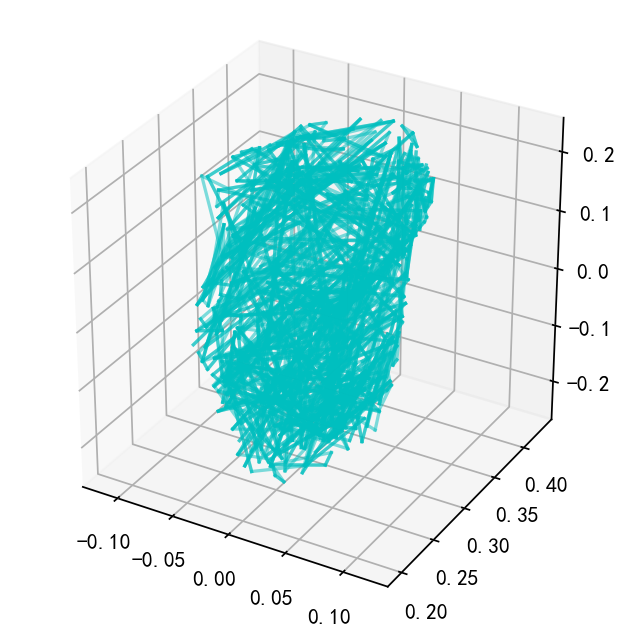

(-0.09266605, 0.09871305, 0.18416655, 0.44333645000000005)

In [48]:
fig = plt.figure(figsize=(4,4))
ax = Axes3D(fig)
# ax.scatter3D(*data.to_numpy().T,marker='.')
for a,b,_ in edges:
    if np.random.rand()>0.:
        ax.plot(*data.iloc[[a,b]].to_numpy().T,alpha=0.5,color='c')
ax.axis('equal')

<IPython.core.display.Javascript object>


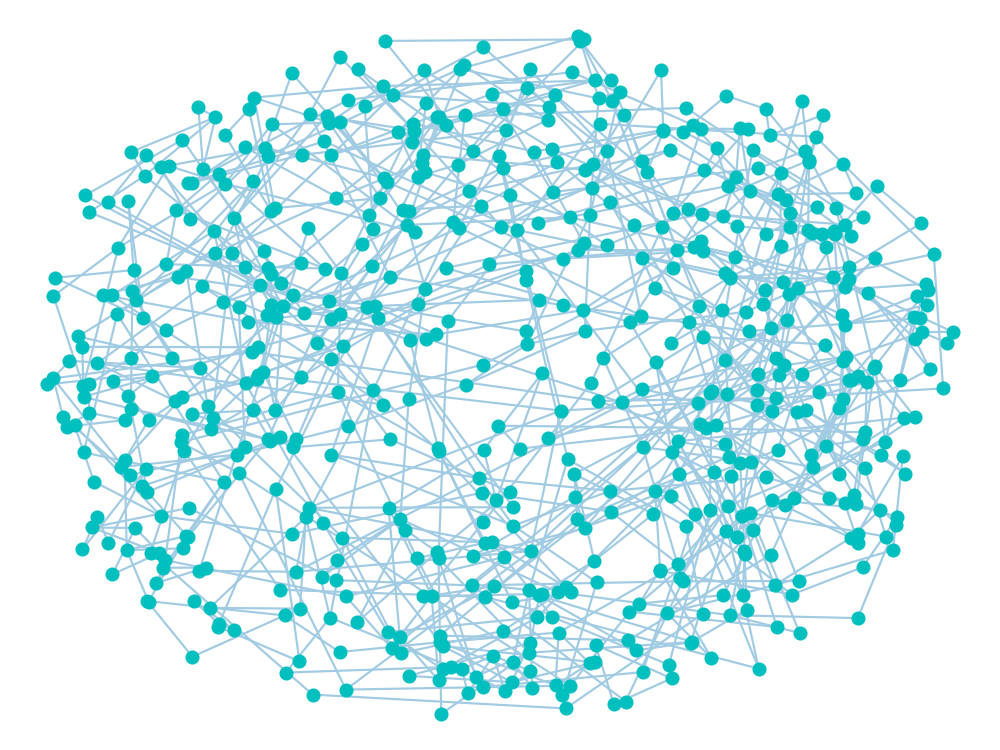

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


In [49]:
plt.figure()
nx.draw(G3,node_shape='o',node_size=30,node_color='c',edge_color='#A0CBE2')

In [133]:
edge2json(G3)